In [199]:
import pymc as pm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

def check_diagnostics(idata, var_names=["~mu", "~alpha", "~B_raw"]):
    """
    Check the diagnostics of a Bayesian model inference data.

    Parameters:
        idata (arviz.InferenceData): The inference data object.
        var_names (list, optional): List of variable names to include in the diagnostics.
            If not provided, all variables will be included. Default is None.

    Returns:
        dict: A dictionary containing the diagnostics of the model inference data.

    """
    diagnostics = {}
    diagnostics["Total divergences"] = idata.sample_stats["diverging"].sum().values
    diagnostics["Max Rhat"] = az.summary(idata, var_names=var_names)["r_hat"].max()
    diagnostics["Min effective sample size(bulk)"] = az.summary(
        idata, var_names=var_names
    )["ess_bulk"].min()
    diagnostics["Min effective sample size(tail)"] = az.summary(
        idata, var_names=var_names
    )["ess_tail"].min()
    diagnostics["Min BFMI"] = az.bfmi(idata).min()

    print("Total divergences: ", diagnostics["Total divergences"])
    print("Max Rhat: ", diagnostics["Max Rhat"])
    print(
        "Min effective sample size(bulk): ",
        diagnostics["Min effective sample size(bulk)"],
    )
    print(
        "Min effective sample size(tail): ",
        diagnostics["Min effective sample size(tail)"],
    )
    print("Min BFMI: ", diagnostics["Min BFMI"])

    # check if any of the diagnostics are bad
    if (
        diagnostics["Total divergences"] > 0
        or diagnostics["Max Rhat"] > 1.1
        or diagnostics["Min effective sample size(bulk)"] < 200
        or diagnostics["Min effective sample size(tail)"] < 200
        or diagnostics["Min BFMI"] < 0.3
    ):
        print("Bad diagnostics, increase tuning or check model")
        diagnostics["success"] = False
        return diagnostics
    else:
        print("Good diagnostics, continue")
        diagnostics["success"] = True
        return diagnostics





In [15]:
df = pd.read_csv('./Book1.csv')
df.head()

df = df.sort_values('Year')
df.head()

,Unnamed: 0,Year,Sex,Age Group,Estimated Number,Population,Crude Rate,Age-Adjusted Rate,Cases (Sample),Standard Error,CV,Lower 95% CI,Upper 95% CI
20,104,2001,Females,10 to 14,"2,877","10,231,469",28.12,--,73,616,21.40%,"1,669","4,084"
19,103,2002,Females,10 to 14,NaN,"10,371,422",NaN,--,--,--,--,--,--
18,102,2003,Females,10 to 14,"2,596","10,444,875",24.86,--,72,548,21.10%,"1,522","3,670"
17,101,2004,Females,10 to 14,"4,264","10,443,706",40.83,--,103,826,19.40%,"2,646","5,883"
16,100,2005,Females,10 to 14,"2,967","10,348,382",28.67,--,85,710,23.90%,"1,576","4,359"


In [142]:
df = df.replace(',','', regex=True)
df = df.dropna()
df['Year'] = df['Year'].astype('int')
y = df['Estimated Number'].astype('int')
X = df['Year'] - df['Year'].min()


In [173]:
with pm.Model() as gp_model:
    X_t = pm.Data('X_t', X.values[:,None])
    beta = pm.Normal('beta', 0, 1)
    alpha = pm.Normal('alpha', 0,5)
    const_func = pm.gp.mean.Linear(coeffs=beta, intercept=alpha )
    cov = pm.gp.cov.ExpQuad(1, ls=2)
    
    gp = pm.gp.Latent(mean_func = const_func, cov_func=cov)

    f = gp.prior("f", X=X_t)
    sigma = pm.Exponential('sigma', .1)
    expected = pm.Deterministic('expected', pm.math.exp(f))
    mean_func = pm.Deterministic('mean_func', pm.math.exp(alpha + beta * X))
    y_ = pm.NegativeBinomial('y_', mu=expected, alpha=sigma, observed=y )

/opt/homebrew/anaconda3/envs/mlc/lib/python3.11/site-packages/pymc/data.py:406: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


In [174]:
with gp_model:
    idata = pm.sample(target_accept=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, f_rotated_, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


In [187]:
check_diagnostics(idata)

/opt/homebrew/anaconda3/envs/mlc/lib/python3.11/site-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['mu', 'B_raw'] have not been found and will be ignored
  warnings.warn(
/opt/homebrew/anaconda3/envs/mlc/lib/python3.11/site-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['mu', 'B_raw'] have not been found and will be ignored
  warnings.warn(


Total divergences:  0
Max Rhat:  1.0
Min effective sample size(bulk):  1309.0
Min effective sample size(tail):  1505.0
Min BFMI:  0.6801381112467129
Good diagnostics, continue


/opt/homebrew/anaconda3/envs/mlc/lib/python3.11/site-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['mu', 'B_raw'] have not been found and will be ignored
  warnings.warn(


{'Total divergences': array(0),
 'Max Rhat': 1.0,
 'Min effective sample size(bulk)': 1309.0,
 'Min effective sample size(tail)': 1505.0,
 'Min BFMI': 0.6801381112467129,
 'success': True}

In [188]:
with gp_model:
    ppc = pm.sample_posterior_predictive(idata, var_names=['expected', 'y_','mean_func'])

Sampling: [y_]


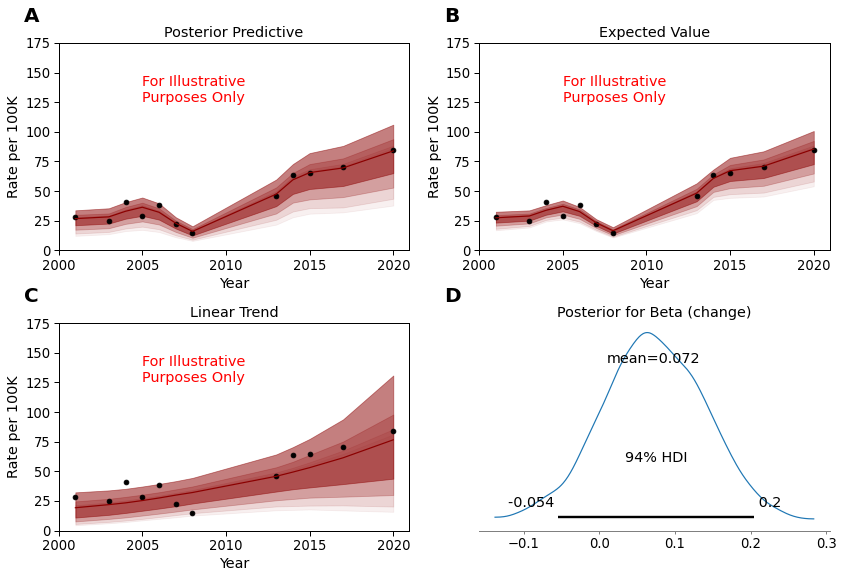

In [198]:

    
post_y = ppc.posterior_predictive['y_']


sns.set_context('paper', font_scale=1.5)   
fig, ax = plt.subplots(2,2, figsize=(12,8))

plt.sca(ax[0][0])
pop = df['Population'].astype('int').values /100000
plt.plot(df['Year'], np.median(post_y, axis=(0,1))/pop, color='darkred')
for q in [94, 89, 75, 50]:
    low = np.percentile(post_y, axis=(0,1), q=(100-q)/2)/pop
    high = np.percentile(post_y, axis=(0,1), q=100-q/2)/pop
    plt.fill_between(df['Year'], low, high, alpha=(100-q)/100, color='darkred')

plt.scatter(df['Year'], y/pop, color='k')

plt.text(x=2005, y=125,s='For Illustrative \nPurposes Only', color='red')
plt.xticks([2000, 2005, 2010, 2015, 2020])
plt.xlabel('Year')
plt.ylabel('Rate per 100K')
plt.title('Posterior Predictive')
plt.ylim(0,175)
plt.sca(ax[0][1])
post_exp = ppc.posterior_predictive['expected']

pop = df['Population'].astype('int').values /100000
plt.plot(df['Year'], np.median(post_exp, axis=(0,1))/pop, color='darkred')
for q in [94, 89, 75, 50]:
    low = np.percentile(post_exp, axis=(0,1), q=(100-q)/2)/pop
    high = np.percentile(post_exp, axis=(0,1), q=100-q/2)/pop
    plt.fill_between(df['Year'], low, high, alpha=(100-q)/100, color='darkred')

plt.scatter(df['Year'], y/pop,color='k')
plt.xticks([2000, 2005, 2010, 2015, 2020])
plt.xlabel('Year')
plt.ylabel('Rate per 100K')
plt.text(x=2005, y=125,s='For Illustrative \nPurposes Only', color='red')

plt.title('Expected Value')
plt.ylim(0,175)
plt.sca(ax[1][0])
plt.text(x=2005, y=125,s='For Illustrative \nPurposes Only', color='red')
post_exp = ppc.posterior_predictive['mean_func']

pop = df['Population'].astype('int').values /100000
plt.plot(df['Year'], np.median(post_exp, axis=(0,1))/pop, color='darkred')
for q in [94, 89, 75, 50]:
    low = np.percentile(post_exp, axis=(0,1), q=(100-q)/2)/pop
    high = np.percentile(post_exp, axis=(0,1), q=100-q/2)/pop
    plt.fill_between(df['Year'], low, high, alpha=(100-q)/100, color='darkred')

plt.scatter(df['Year'], y/pop,color='k')
plt.xticks([2000, 2005, 2010, 2015, 2020])
plt.xlabel('Year')
plt.ylabel('Rate per 100K')
plt.title('Linear Trend')
plt.ylim(0,175)
plt.tight_layout()

plt.sca(ax[1][1])
az.plot_posterior(idata.posterior['beta'].values.ravel(), ax=ax[1][1])
plt.title('Posterior for Beta (change)')
import string
for n, ax in enumerate(ax.flatten()):
    ax.text(
        -0.1,
        1.1,
        string.ascii_uppercase[n],
        transform=ax.transAxes,
        size=20,
        weight="bold",
    )